# Question 3
### Model degradation is a common issue faced when deploying neural network models in the real world. In typical coursework settings, you learn the ropes by experimenting on toy datasets, which only offers a static snapshot of the situation. Real life problems, such as the analysis of factors influencing HDB prices, have new data points coming in daily that might exhibit a different pattern from older data points due to factors such as changes in government policy or market sentiments. In such situations, models trained on older data points that differ greatly from the new data could perform poorly. In the last part of this assignment, we will investigate whether this has happened. There are 2 datasets to work with: ‘HDB_price_prediction.csv’ and ‘HDB_price_prediction_old.csv’. The latter is a subset of the former: both start from the same date but the latter ends on August 2021 while the former has data until August 2022. Both have the same set of training data (2020 and before) but the test data for the latter (i.e. ‘old test set’) is up till August 2021, while the test set from the former has complete data from 2021, along with data till August 2022 (‘new test set’).

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup, Embedding,Input, Reshape

import pandas as pd
df = pd.read_csv('./data/hdb_price_prediction.csv')
df

2022-10-10 22:00:10.831945: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-10 22:00:10.831968: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [2]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


### Callbacks

In [3]:
from keras import backend as K

def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [4]:
# early stop callback
def early_stop_callback():
  return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

## a) Apply your model from Q2d on the ‘old test set’. On the ‘new test set’, split it into 2021 and 2022. For all 3 test sets, report the test R 2 value you obtained.

In [5]:
from sklearn.preprocessing import LabelEncoder

# function to factorise categorical features as the DNN expects numbers and not strings
def preprocess_df(df):
    category_features = [ 'month', 'flat_model_type', 'storey_range']
    numeric_features = ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality',
'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']

    for feature in category_features:
        encoder = LabelEncoder()
        df[feature] = encoder.fit_transform(df[feature])
    return df

In [6]:
df_processed = preprocess_df(df)

In [7]:
# dropping irrelevant data , drop 'year' & 'resale_price' later
df_cleaned = df_processed.drop(['full_address','nearest_stn'],axis=1)

# Split data to train data (<2020 && >2020) and test data (== 2020)
train_dataframe = df_cleaned[df_cleaned.year<=2020]
val_dataframe_old = df_cleaned[(df_cleaned.year==2021)&(df_cleaned.month<=8)]
val_dataframe_new_2021 = df_cleaned[df_cleaned.year==2021]
val_dataframe_new_2022 = df_cleaned[df_cleaned.year==2022]


# drop the remaining year data
train_dataframe = train_dataframe.drop(['year'],axis=1)
val_dataframe_old = val_dataframe_old.drop(['year'],axis=1)
val_dataframe_new_2021 = val_dataframe_new_2021.drop(['year'],axis=1)
val_dataframe_new_2022 = val_dataframe_new_2022.drop(['year'],axis=1)

In [8]:
train_ds = dataframe_to_dataset(train_dataframe)
val_ds_old = dataframe_to_dataset(val_dataframe_old)
val_ds_new_2021 = dataframe_to_dataset(val_dataframe_new_2021)
val_ds_new_2022 = dataframe_to_dataset(val_dataframe_new_2022)



train_ds = train_ds.batch(256)
val_ds_old = val_ds_old.batch(256)
val_ds_new_2021 = val_ds_new_2021.batch(256)
val_ds_new_2022 = val_ds_new_2022.batch(256)

2022-10-10 22:00:16.545242: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 22:00:16.545745: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-10 22:00:16.545868: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-10 22:00:16.545981: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-10 22:00:16.548707: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

## b) The team that produced the linear regression model shared with you their results (test R 2 values): 0.76 on the old test set, 0.715 when only using 2021 data as test set and 0.464 when only using 2022 data as test set. 2 In light of this (along with their result in Q1b and your results from Q3a), compare the extent to which model degradation has impacted your model to that of the team’s linear regression model and explain why this has occurred.

In [9]:
# loading already trained_model withh best weights according to loss to avoid training everytime
best_model = tf.keras.models.load_model('./data/models/PartB_Q2/2d/best_model',custom_objects ={'r2':r2})

### report the test R 2 value you obtained for old vs new test dataset:

In [10]:
result = best_model.evaluate(val_ds_old,verbose=0)
print('old test set r2:{}'.format(result[1]))
result = best_model.evaluate(val_ds_new_2021,verbose=0)
print('new test set r2 (2021):{}'.format(result[1]))
result = best_model.evaluate(val_ds_new_2022,verbose=0)
print('new test set r2 (2022):{}'.format(result[1]))

old test set r2:0.8047308325767517
new test set r2 (2021):0.7769935727119446
new test set r2 (2022):0.5551515817642212


For the team's linear regression model. The model has degraded by r2 = 0.76-0.464 = 0.296
For our model, the model has degraded r2 = 0.805 - 0.555 = 0.25
Our model has degraded to a lesser extent as compared to the linear regression model provided by the team. This occurs because our NN model is able to capture relations between features which are non linear in nature better than a linear regression model, because our neural network retains more information, the model degradation effect affects us less as a whole as compared to the linear regression model

## c) Model degradation could be caused by various data distribution shifts 2 : covariate shift (features), label shift and/or concept drift (altered relationship between features and labels). Recall that machine learning models generally need the test data distribution to be similar to the training data distribution.

* covariate shift (features)
    - P(X) changes
* label shift
    - P(Y) changes
* concept drift
    - P(Y|X) changes

### Label Shifts:

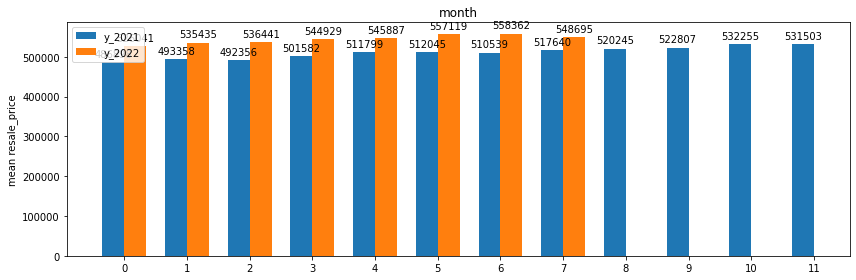

In [53]:
# 2021 month-x vs valuecount
val_dataframe_new_2021['month'].unique()
val_dataframe_new_2021[val_dataframe_new_2021.month==0]['resale_price'].mean()
x= val_dataframe_new_2021['month'].unique()
y_2021=[ val_dataframe_new_2021[val_dataframe_new_2021.month==month]['resale_price'].mean() for month in x]
y_2022=[ val_dataframe_new_2022[val_dataframe_new_2022.month==month]['resale_price'].mean() for month in x]

x = np.arange(len(val_dataframe_new_2021['month'].unique()))
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_figwidth(12)

rects1 = ax.bar(x - width/2, y_2021, width, label='y_2021')
rects2 = ax.bar(x + width/2, y_2022, width, label='y_2022')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('mean resale_price')
ax.set_title('month')
ax.set_xticks(x, val_dataframe_new_2021['month'].unique())
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

There is a Label shift as we can see that the resale price has been on the generalise rise month after month, year after year.

### Visualising Covariate Shifts:

In [64]:
numerical_features = ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality','eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']

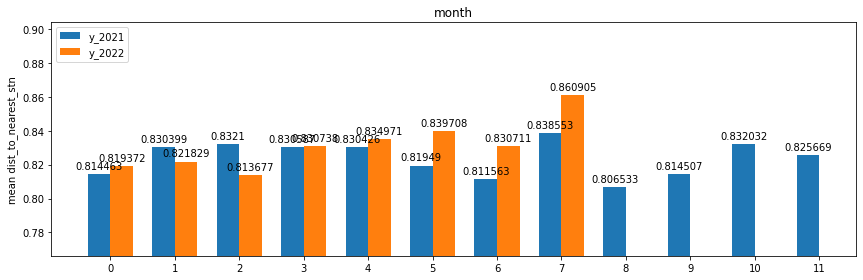

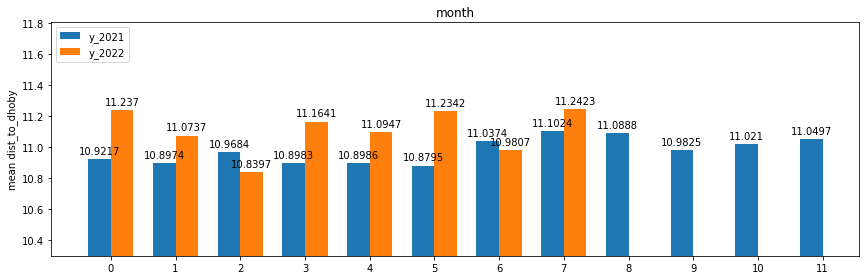

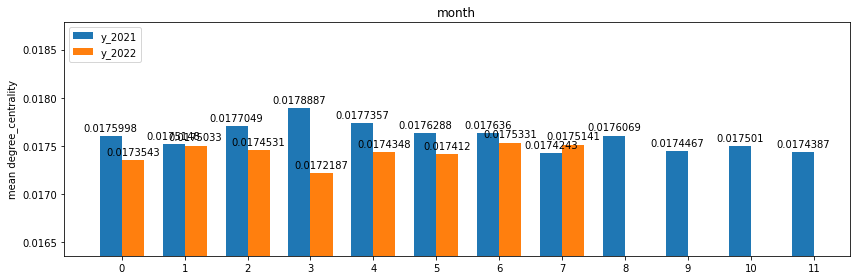

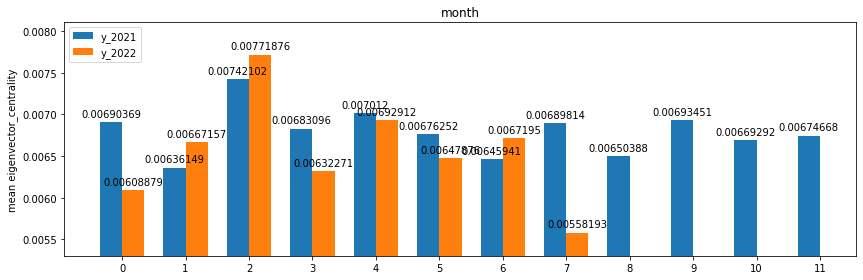

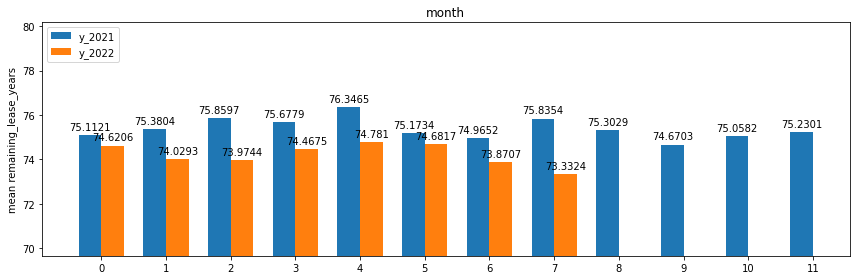

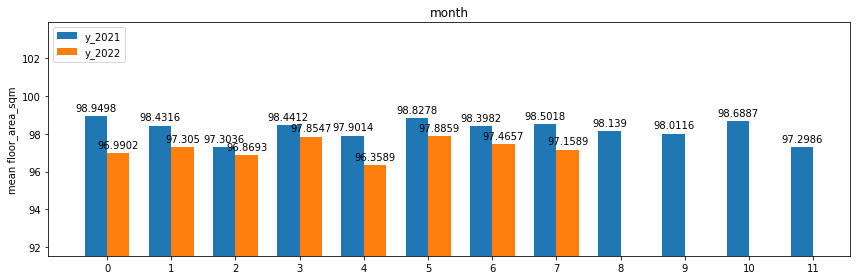

In [87]:
for numerical_feature in numerical_features:
    # 2021 month-x vs valuecount
    val_dataframe_new_2021['month'].unique()
    val_dataframe_new_2021[val_dataframe_new_2021.month==0][numerical_feature].mean()
    x= val_dataframe_new_2021['month'].unique()
    y_2021=[ val_dataframe_new_2021[val_dataframe_new_2021.month==month][numerical_feature].mean() for month in x]
    y_2022=[ val_dataframe_new_2022[val_dataframe_new_2022.month==month][numerical_feature].mean() for month in x]

    x = np.arange(len(val_dataframe_new_2021['month'].unique()))
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    fig.set_figwidth(12)

    rects1 = ax.bar(x - width/2, y_2021, width, label='y_2021')
    rects2 = ax.bar(x + width/2, y_2022, width, label='y_2022')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('mean {}'.format(numerical_feature))
    ax.set_title('month')
    ax.set_xticks(x, val_dataframe_new_2021['month'].unique())
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    temp = y_2021+y_2022
    newlist = [x for x in temp if pd.isnull(x) == False and x != 'nan']

    ax.set_ylim(bottom=0.95*np.min(newlist))
    plt.margins(y=0.85)
    plt.show()

All features seem to have undergone a covariate shift from 2021 to 2022. features from 2022 vary vastly from 2021

seems like for there was no covariate shift mean dist_to_nearest station did not change from 2021 to 2022

In [36]:
for month in x:
    print(month)

0
1
2
3
4
5
6
7
8
9
10
11


In [37]:
[ val_dataframe_new_2021[val_dataframe_new_2021.month==month]['dist_to_nearest_stn'].mean() for month in x]

[0.8144632364355421,
 0.8303994782348786,
 0.8321002088813052,
 0.8305871864318561,
 0.830426192419002,
 0.8194903047691466,
 0.8115631471819581,
 0.8385533552119047,
 0.8065327504716113,
 0.814507192298886,
 0.8320323509500994,
 0.8256691902356462]

In [11]:
category_features = [ 'month', 'flat_model_type', 'storey_range']
numeric_features = ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality',
'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']

# d) The team passed you a script (‘RFE.py’) that recursively removes features from a neural network, so as to find the best feature subset. Run this piece of code with your model from Q2d and report the best feature subset obtained.

In [12]:
# dropping irrelevant data , drop 'year' & 'resale_price' later
df_cleaned = df_processed.drop(['full_address','nearest_stn'],axis=1)

# Split data to train data (<2020 && >2020) and test data (== 2020)
train_dataframe = df_cleaned[df_cleaned.year<2020]
val_dataframe = df_cleaned[df_cleaned.year == 2020]

# drop the remaining year data
train_dataframe = train_dataframe.drop(['year'],axis=1)
val_dataframe = val_dataframe.drop(['year'],axis=1)

In [13]:
train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)

In [15]:
"""
Implementation of recursive feature elimination algorithm for neural networks.

Recursive feature elimination (RFE) is a feature selection method that removes unnecessary features from the inputs. 
It can also shed some insights on how much each feature contributes to the prediction task.

The algorithm starts by removing one input feature whose removal leads to the minimum drop (or maximum improvement) in performance. 
- Given k features, to determine which of the k features will cause the minimum drop / maximum increase when that feature is removed, you will have to perform k experiments. After removing that feature, k-1 features will be left and you will have to perform k-1 experiments to determine the next feature to remove.
    - In the case removing a feature leads to an improvement from the baseline (all features used), that feature is likely not useful since removing it actually helped the model to perform better.
    - There will also be cases when all subsets with k-1 features do not do better than the baseline model. In that case, it is likely that all features are useful. You can get a sense of which are more useful than others by looking at the increase in error that occurs when the feature is removed.

This procedure is repeated recursively on the reduced input set until the optimal number of input features is reached. 
- The feature removal goes on until either 1 feature is left, or the model performance does not improve from the previous best (e.g. when there are 7 features left, if none of the 7 experiments performed does better than the best performance of the model with 8 features, the RFE algorithm terminates).
- The condition to stop the recursive process once all (k-1)-features models do worse than the best k-features model was added to make the algorithm terminate earlier so that you don't have to run too many iterations. Also, if the condition happens, then subsequent search is likely to be fruitless (it's always possible for the contrary to happen, but the chances are low and it's usually not worth the additional time).

Each model should use a different subset of features and they are trained independently. There is no loading of weights from any previous models.


In the code below, a boolean mask `vec` is used to keep track of which features to select during the iteration. 

You need to place your model training code into the 'train_model' function and have it return the validation loss.

Look out for the comments labelled 'TODO'.

"""

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)


import time
start = time.time()

num_features = 9

vec = [1 for i in range(num_features)]
best_loss = 1e15
new_best_loss = 1e14
which_iter = ''

all_losses = [] # should be len 9,8,7,...


def train_model(feature_mask):
    """
    Given a boolean mask (feature_mask), select the features accordingly, train the model and return the validation loss.
    """
    
    feature_mask_string = ''.join([str(i) for i in feature_mask])
    
    # TODO: define the input layer here (your code from Q2)
    
    optimum_divisor = 2
    
    # building input layer
    numerical_features = ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality','eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']
    categorical_features = [ 'month', 'flat_model_type', 'storey_range']
    
    # keeping track of each category's cardinality in a dict
    num_categorical_dict = {}

    for feature in categorical_features:
        num_categorical_dict[feature] = df_cleaned[feature].nunique()

    # building an embedding layer for each category column
    inputs = []
    models= []
    
    for cat,categorical_size in num_categorical_dict.items():

        output_dim = categorical_size//optimum_divisor
        vocab_size = categorical_size

        # input layer for categorical data only takes 1 row
        inpt = keras.Input(shape=(1,),name=cat)

        # embed layer for categorical data 
        embed = Embedding(vocab_size,
                          output_dim,
                          trainable=True,
                          embeddings_initializer=tf.initializers.random_normal)(inpt)
        # reshape embed layer
        # to be replaced by flatten
        embed_reshaped = Reshape(target_shape=(output_dim,))(embed)
        models.append(embed_reshaped)
        inputs.append(inpt)
        
    # building layers for Numerical features    
    dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
    dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
    degree_centrality =keras.Input(shape=(1,), name="degree_centrality")
    eigenvector_centrality=keras.Input(shape=(1,), name="eigenvector_centrality")
    remaining_lease_years=keras.Input(shape=(1,), name="remaining_lease_years")
    floor_area_sqm =keras.Input(shape=(1,), name="floor_area_sqm")

    # append all numerical inputs
    inputs.append(dist_to_nearest_stn)
    inputs.append(dist_to_dhoby)
    inputs.append(degree_centrality)
    inputs.append(eigenvector_centrality)
    inputs.append(remaining_lease_years)
    inputs.append(floor_area_sqm)

    # encode all numerical features
    # Numerical features
    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn,'dist_to_nearest_stn',train_ds)
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby,'dist_to_dhoby',train_ds)
    degree_centrality_encoded = encode_numerical_feature(degree_centrality,'degree_centrality',train_ds)
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality,'eigenvector_centrality',train_ds)
    remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years,'remaining_lease_years',train_ds)
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm,'floor_area_sqm',train_ds)

    #return encoded inputs
    models+=[dist_to_nearest_stn_encoded,
             dist_to_dhoby_encoded,
             degree_centrality_encoded,
             eigenvector_centrality_encoded,
             remaining_lease_years_encoded,
             floor_area_sqm_encoded]
    # merging embedded categorical layers and numerical layers to a single input layer
    
    #all_features = layers.concatenate(models)
    all_features_input = models
    # break
    selected_inputs = []
    print('going through feature_mask', feature_mask)
    for i,j in zip(all_features_input, feature_mask):
        if j == 1:
            selected_inputs.append(i)
            print(i)
        else:
            print('Skipping', i)

    all_features = layers.concatenate(selected_inputs)
    
    # TODO: Complete the rest of the architecture + training code and retrieve the training history
    
    
    # building the rest of the model
    optimum_units = 16
    optimum_learning_rate = 0.06805250998340012
    hidden_layer = layers.Dense(units=optimum_units,
                                activation='relu')(all_features)

    output_layer = layers.Dense(1,activation='linear')(hidden_layer)

    optimum_model = keras.Model(inputs,output_layer)

    # compiling the model
    optimum_model.compile(optimizer = tf.keras.optimizers
                      .Adam(learning_rate = optimum_learning_rate),
                      metrics = [r2,tf.keras.metrics.RootMeanSquaredError()],loss='mean_squared_error')

    # fit and save the optimum model
    history = optimum_model.fit(train_ds,
                                epochs=50,
                                validation_data=val_ds,
                                verbose=0,
                                callbacks=[early_stop_callback()])
    
    val_loss_hx = history.history['root_mean_squared_error'] # NOTE: You can use RMSE if you find it easier to interpret.
    val_loss_min = min(val_loss_hx)
    
    return val_loss_min


## RFE starts here 

while sum(vec) > 0 and best_loss > new_best_loss:
    
    print('vec', vec)

    best_loss = new_best_loss
    new_min_loss_flag = False
    
    losses_from_same_vec = []
    
    for ix, i in enumerate(vec):
        
        print('ix', ix, 'i', i)
        
        if i == 0:
            continue # if the feature is off, no need to do anything, go to next position
        else:
            temp_vec = vec[:]
            temp_vec[ix] = 0 # turn off the feature
            print('updated temp_vec', temp_vec)
            
            loss = train_model(temp_vec)
            losses_from_same_vec.append(loss)
            
            if loss < new_best_loss:
                new_best_loss = loss
                which_iter = 'len ' + str(sum(vec)) + ', ix ' + str(ix)
                print('new min loss:', which_iter)
                new_min_loss_flag = True
                min_loss_vec = temp_vec[:]

            tf.keras.backend.clear_session()
            print('session cleared!\n')
                
    
    all_losses.append(losses_from_same_vec)
    
    # After going through the vec once, update vec if new min loss    
    if new_min_loss_flag:
        vec = min_loss_vec
    
    # else case means no new min loss, the latter while loop condition will cause it to terminate 
    print(time.time() - start, 'seconds elapsed')
    print()

print(all_losses)


vec [1, 1, 1, 1, 1, 1, 1, 1, 1]
ix 0 i 1
updated temp_vec [0, 1, 1, 1, 1, 1, 1, 1, 1]
going through feature_mask [0, 1, 1, 1, 1, 1, 1, 1, 1]
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='reshape_3/Reshape:0', description="created by layer 'reshape_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 22), dtype=tf.float32, name=None), name='reshape_4/Reshape:0', description="created by layer 'reshape_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), name='reshape_5/Reshape:0', description="created by layer 'reshape_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_6/truediv:0', description="created by layer 'normalization_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_7/truediv:0', description="created by layer 'normalization_7'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float3

new min loss: len 9, ix 5
session cleared!

ix 6 i 1
updated temp_vec [1, 1, 1, 1, 1, 1, 0, 1, 1]
going through feature_mask [1, 1, 1, 1, 1, 1, 0, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='reshape/Reshape:0', description="created by layer 'reshape'")
KerasTensor(type_spec=TensorSpec(shape=(None, 22), dtype=tf.float32, name=None), name='reshape_1/Reshape:0', description="created by layer 'reshape_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), name='reshape_2/Reshape:0', description="created by layer 'reshape_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization/truediv:0', description="created by layer 'normalization'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_1/truediv:0', description="created by layer 'normalization_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, na

session cleared!

ix 3 i 1
updated temp_vec [1, 1, 1, 0, 1, 0, 1, 1, 1]
going through feature_mask [1, 1, 1, 0, 1, 0, 1, 1, 1]
KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='reshape/Reshape:0', description="created by layer 'reshape'")
KerasTensor(type_spec=TensorSpec(shape=(None, 22), dtype=tf.float32, name=None), name='reshape_1/Reshape:0', description="created by layer 'reshape_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), name='reshape_2/Reshape:0', description="created by layer 'reshape_2'")
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization/truediv:0', description="created by layer 'normalization'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_1/truediv:0', description="created by layer 'normalization_1'")
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)

In [18]:
class_names = ['dist_to_nearest_stn', 
               'dist_to_dhoby', 
               'degree_centrality',
               'eigenvector_centrality', 
               'remaining_lease_years', 
               'floor_area_sqm','month', 
               'flat_model_type', 
               'storey_range']
first_feature = class_names[np.argmax(all_losses[0])]
print('best feature: {}'.format(first_feature))

class_names.remove(first_feature)
second_feature = class_names[np.argmax(all_losses[1])]
print('2nd best features: {}'.format(second_feature))

best feature: remaining_lease_years
2nd best features: floor_area_sqm


on each iteration, the RFE code finds the best feature to eliminate. 
The best feature is found by testing combinations where a feature is left out in the model, then by finding the resultant RMSE of that model. 
The best feature can be deduced when the RMSE of the model is highest when the feature is left out, indicating that there is the highest errors in the model when that feature was left out.
The best feature that was left out is the remaining_lease_years feature

Then we remove the best feature from the model, and try the process iteratively to find the second best feature, which is floor_area_sqm. 

# e) RFE on the ‘old test set’ eliminated features degree_centrality and month. It also showed that dist_to_dhoby and dist_to_nearest_stn are crucial (removing them leads to higher test loss). Compare these features to those in Q3d and discuss whether concept drift has occurred.

Concept drift occurs when P(Y|X) changes, which also means that the predicted field is less/more related to a certain predictor(feature). In our case, Concept drift seems to have occured from the old to the new dataset. This is evident in the model tested on newer test data, the best features were identified as dist_to_nearest_stn and floor_area_sqm.

However, when the same model is conducted on a older test data, the most crucial features identified were dist_to_dhoby and dist_to_nearest_stn. It seems that as time passed,dist_to_dhoby became less related to the predictor than floor_area_sqm. It also seems that dist_to_nearest_stn remains important through the years